### WPM ratios

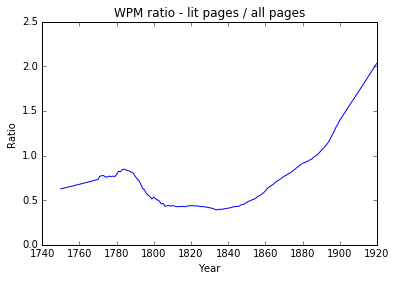

In [1]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

from hol.wpm_ratios import WPMRatios

ratios = WPMRatios(1750, 1920)

series = ratios.series_smooth('jesus')

plt.title('WPM ratio - lit pages / all pages')
plt.xlabel('Year')
plt.ylabel('Ratio')
plt.plot(*zip(*series.items()))